# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

!pip install wordcloud
!pip install gTTs
!pip install playsound

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting graphs
import seaborn as sns 
import glob

from skimage import io
pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption

import collections
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from gtts import gTTS
from playsound import playsound
from IPython import display

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

  Using cached wordcloud-1.8.2.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Using cached gTTS-2.3.1-py3-none-any.whl (28 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Using cached playsound-1.3.0-py3-none-any.whl
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


/tmp/ipykernel_303/4254563312.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption
playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [3]:
!nvidia-smi  # We having Nvidia RTX A6000

Wed Apr 19 11:59:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:B1:00.0 Off |                  Off |
| 30%   29C    P8    25W / 300W |      0MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
# Download Dataset from Google Drive using gdown cmd
# !gdown 1bQiXinPaTYasWXv9dr6xIXypA0SMSi0b 
# Unzip the Dataset file
# !unzip Flickr8k.zip

In [5]:
#Import the dataset and read the image into a seperate variable

images_path = "Flickr8k/Images/"
texts_file = "Flickr8k/captions.txt"

all_imgs = glob.glob(images_path + '*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


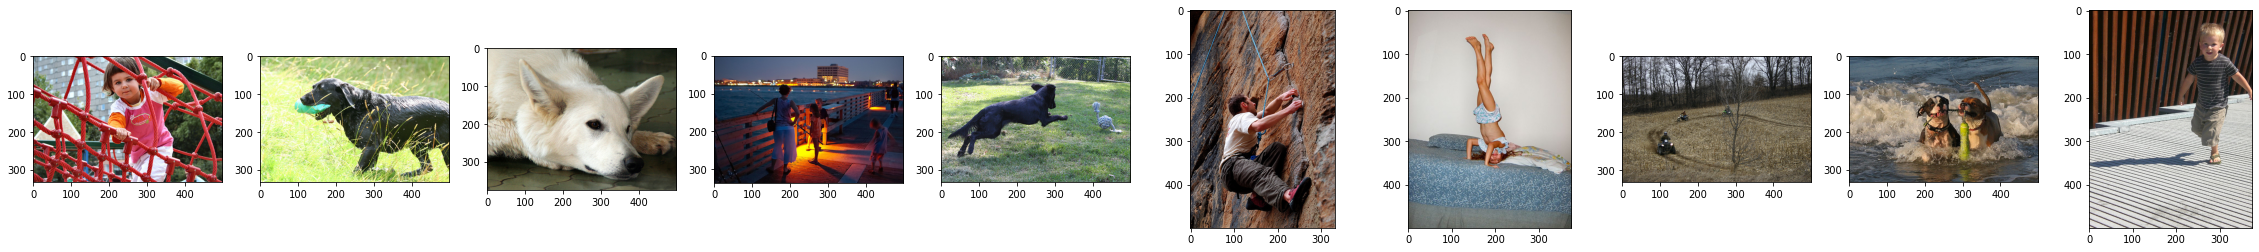

In [6]:
#Visualise both the images & text present in the dataset

#Visualising first 10 images:
Display_Images= all_imgs[0:10]
figure, axes = plt.subplots(1,10)
figure.set_figwidth(40)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [7]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    open_file = open(filename, 'r', encoding="latin-1") #associate and returns a file object
    text = open_file.read() #for reading the content of the file
    open_file.close()   
    
    return text

doc = load_doc(texts_file)
print(doc[:300])


image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here


with open(texts_file, 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(images_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201_693b08cb0e.jpg,Flickr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,Flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,Flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,Flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin
...,...,...,...
40450,997722733_0cb5439472.jpg,Flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,Flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,Flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles
40453,997722733_0cb5439472.jpg,Flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt


* We can see that we had both A and a are counted separately. So,let's convert all words to lower case.

In [9]:
# Create the vocabulary & the counter for the captions
vocabulary= [word.lower() for line in annotations for word in line.split()] #We can see that we had both
val_count=collections.Counter(vocabulary)
# val_count

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Counts')

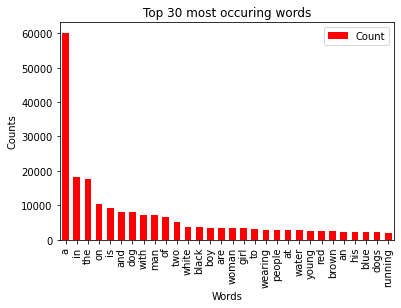

In [10]:
#Visualise the top 30 occuring words in the captions

for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

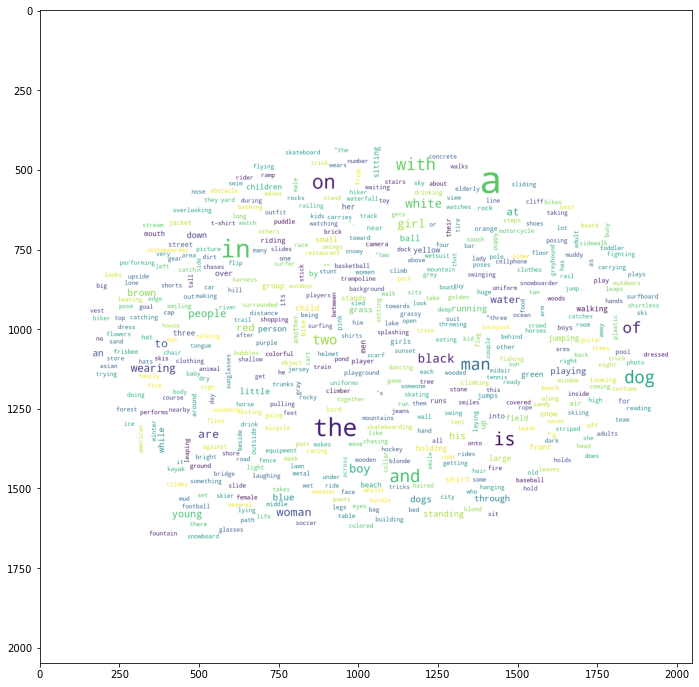

In [11]:
common_mask = np.array(Image.open('comment.png'))
wordcloud = WordCloud(background_color='white',
                    max_words = 500,
                    max_font_size = 120, 
                    random_state = 42,
                    mask = common_mask).generate_from_frequencies(val_count)
plt.figure(figsize=(20.0,12.0))
plt.imshow(wordcloud)

* We can see that stopwords are having higher frequency.Let's find top 30 commom words excluding them.

dog :  7948
man :  7137
two :  5132
white :  3706
black :  3620
boy :  3514
woman :  3304
girl :  3277
wearing :  2916
people :  2811
water :  2676
young :  2587
red :  2553
brown :  2457
blue :  2125
dogs :  2095
running :  1996
playing :  1954
little :  1736
shirt :  1735
standing :  1702
ball :  1678
grass :  1565
person :  1515
child :  1507
snow :  1439
jumping :  1430
front :  1322
sitting :  1322
small :  1257


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'dog'),
  Text(1, 0, 'man'),
  Text(2, 0, 'two'),
  Text(3, 0, 'white'),
  Text(4, 0, 'black'),
  Text(5, 0, 'boy'),
  Text(6, 0, 'woman'),
  Text(7, 0, 'girl'),
  Text(8, 0, 'wearing'),
  Text(9, 0, 'people'),
  Text(10, 0, 'water'),
  Text(11, 0, 'young'),
  Text(12, 0, 'red'),
  Text(13, 0, 'brown'),
  Text(14, 0, 'blue'),
  Text(15, 0, 'dogs'),
  Text(16, 0, 'running'),
  Text(17, 0, 'playing'),
  Text(18, 0, 'little'),
  Text(19, 0, 'shirt'),
  Text(20, 0, 'standing'),
  Text(21, 0, 'ball'),
  Text(22, 0, 'grass'),
  Text(23, 0, 'person'),
  Text(24, 0, 'child'),
  Text(25, 0, 'snow'),
  Text(26, 0, 'jumping'),
  Text(27, 0, 'front'),
  Text(28, 0, 'sitting'),
  Text(29, 0, 'small')])

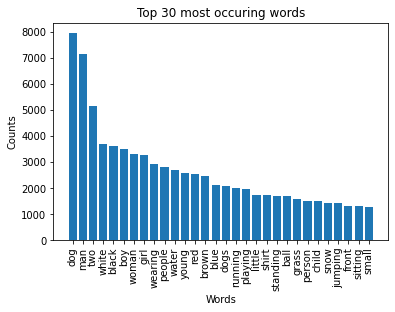

In [12]:
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        print(word, ": ", count)

dict_without_stopwords = {}
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count


#plt.bar(*zip(*dict_without_stopwords.items()))
#plt.show()
plt.bar(range(len(dict_without_stopwords)), dict_without_stopwords.values(), align='center')
plt.xticks(range(len(dict_without_stopwords)), list(dict_without_stopwords.keys()))
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation=90)

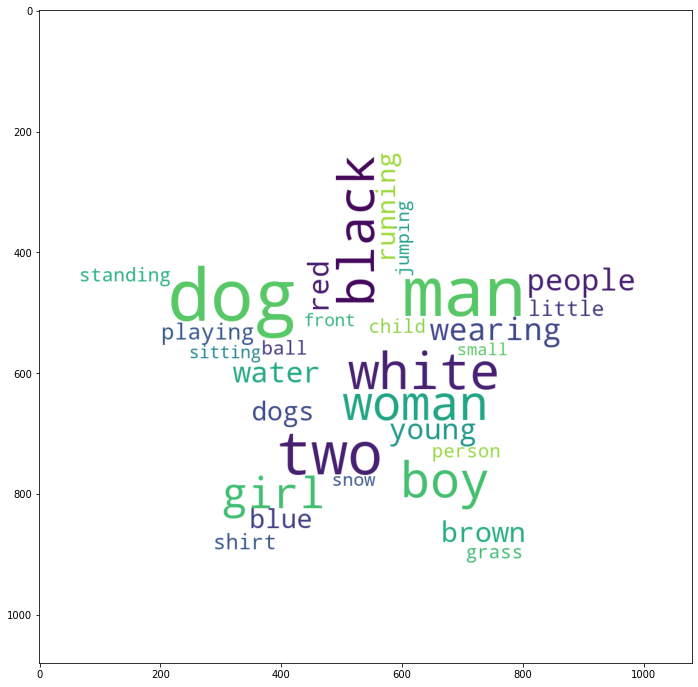

In [13]:
common_mask = np.array(Image.open('star.png'))
wordcloud = WordCloud(background_color='white',
                    max_words = 500,
                    max_font_size = 120, 
                    random_state = 42,
                    mask = common_mask).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize=(20.0,12.0))
plt.imshow(wordcloud)

* Until now we visualized the images and captions separately.Now let's visualize both of them together.

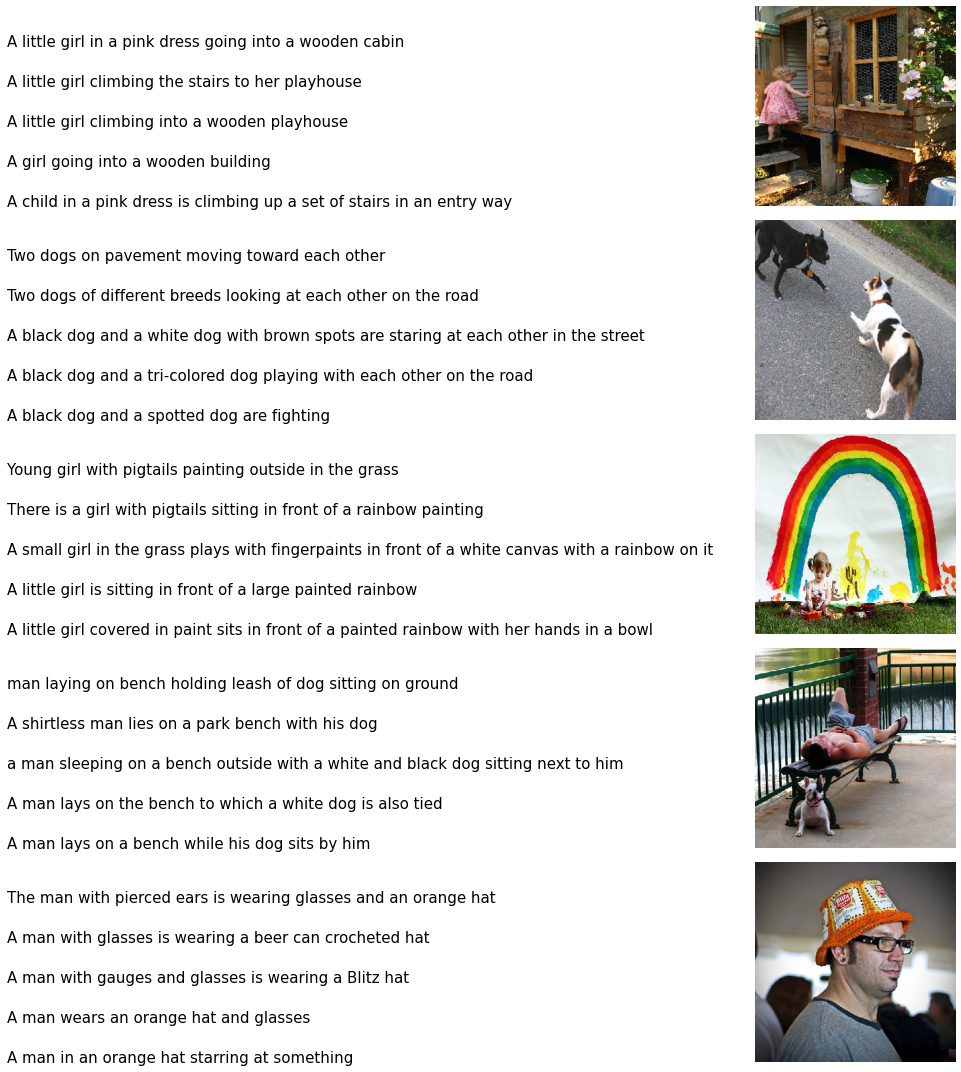

In [14]:

# Images 
fig = plt.figure(figsize=(15,15)) # For dosplaying image
count = 1
    
for Path in df[:25].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()

### Data Cleaning
* Converting all words to lower case
* Removing punctuations
* Retaining only words by removing numbers
* We are not removing stopwords but removing hanging s ,a or any one letter word.
* We are not performing stemming.

In [15]:
# Data cleaning
# prepare translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line]# remove punctuation from each token
    line = [word for word in line if len(word)>1] # remove hanging 's' and 'a'
    line = [word for word in line if word.isalpha()]# remove tokens with numbers in them
    annotations[i]=  ' '.join(line)   # store as string

In [16]:
#Create a list which contains all the captions
annotations = ['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path = all_img_vector

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [17]:
annotations[0:20]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tricolored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>',
 '<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
 '<start> little girl is sitting in front of large painted rainbow <end>',
 '<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>',

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Create the tokenizer
* We have already removed numeric character in previous step.

* Let's remove punctuations using filter again for to be sure(The default is all punctuation, plus tabs and line breaks, minus the ' character.)

* Convert words to lower case (this is also already done.Let's do again to be safe)

* And,replace out-of-vocabulary words with UNK token and assign PAD token for reseved zero index

In [18]:
# create the tokenizer
top_voc = 5000
tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")

In [19]:
# Create word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations) #Updates internal vocabulary based on a list of texts.

train_seqs = tokenizer.texts_to_sequences(annotations)#Transforms each text in texts to a sequence of integers.

# when we use the pad_sequence to process the sequence, we will be using 0 as the padding value.
# In order to distinguish between PAD and UNKNOWN, keras use different index for UNKNOWN.

# 0 is a reserved index that won't be assigned to any word.Let's add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [20]:
print(tokenizer.index_word)

{1: 'UNK', 2: '<start>', 3: '<end>', 4: 'in', 5: 'the', 6: 'on', 7: 'is', 8: 'and', 9: 'dog', 10: 'with', 11: 'man', 12: 'of', 13: 'two', 14: 'white', 15: 'black', 16: 'boy', 17: 'are', 18: 'woman', 19: 'girl', 20: 'to', 21: 'wearing', 22: 'people', 23: 'at', 24: 'water', 25: 'young', 26: 'red', 27: 'brown', 28: 'an', 29: 'his', 30: 'blue', 31: 'dogs', 32: 'running', 33: 'through', 34: 'playing', 35: 'while', 36: 'down', 37: 'little', 38: 'shirt', 39: 'standing', 40: 'ball', 41: 'grass', 42: 'person', 43: 'child', 44: 'snow', 45: 'jumping', 46: 'over', 47: 'three', 48: 'front', 49: 'sitting', 50: 'small', 51: 'field', 52: 'up', 53: 'holding', 54: 'large', 55: 'group', 56: 'by', 57: 'green', 58: 'yellow', 59: 'children', 60: 'walking', 61: 'men', 62: 'her', 63: 'into', 64: 'beach', 65: 'air', 66: 'near', 67: 'jumps', 68: 'mouth', 69: 'street', 70: 'runs', 71: 'for', 72: 'another', 73: 'riding', 74: 'from', 75: 'its', 76: 'as', 77: 'bike', 78: 'stands', 79: 'girls', 80: 'one', 81: 'outsi

In [21]:
print(tokenizer.word_counts)

OrderedDict([('<start>', 40455), ('child', 1517), ('in', 18182), ('pink', 702), ('dress', 332), ('is', 9069), ('climbing', 490), ('up', 1215), ('set', 105), ('of', 6496), ('stairs', 109), ('an', 2358), ('entry', 1), ('way', 48), ('<end>', 40455), ('girl', 3284), ('going', 145), ('into', 1046), ('wooden', 278), ('building', 485), ('little', 1750), ('playhouse', 6), ('the', 17676), ('to', 3005), ('her', 1102), ('cabin', 4), ('black', 3627), ('dog', 7956), ('and', 8057), ('spotted', 36), ('are', 3365), ('fighting', 130), ('tricolored', 12), ('playing', 1954), ('with', 7308), ('each', 399), ('other', 667), ('on', 10367), ('road', 380), ('white', 3710), ('brown', 2471), ('spots', 28), ('staring', 57), ('at', 2819), ('street', 909), ('two', 5546), ('dogs', 2097), ('different', 43), ('breeds', 5), ('looking', 682), ('pavement', 46), ('moving', 40), ('toward', 142), ('covered', 286), ('paint', 57), ('sits', 561), ('front', 1322), ('painted', 62), ('rainbow', 17), ('hands', 231), ('bowl', 29), 

In [22]:
annotations[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [23]:
train_seqs[:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [24]:
print(len(train_seqs))
print(type(train_seqs))

40455
<class 'list'>


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


Text(0, 0.5, 'Counts')

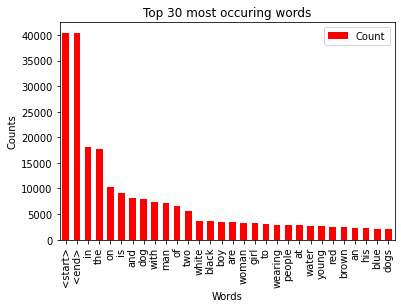

In [25]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
# plt.grid(b=None)

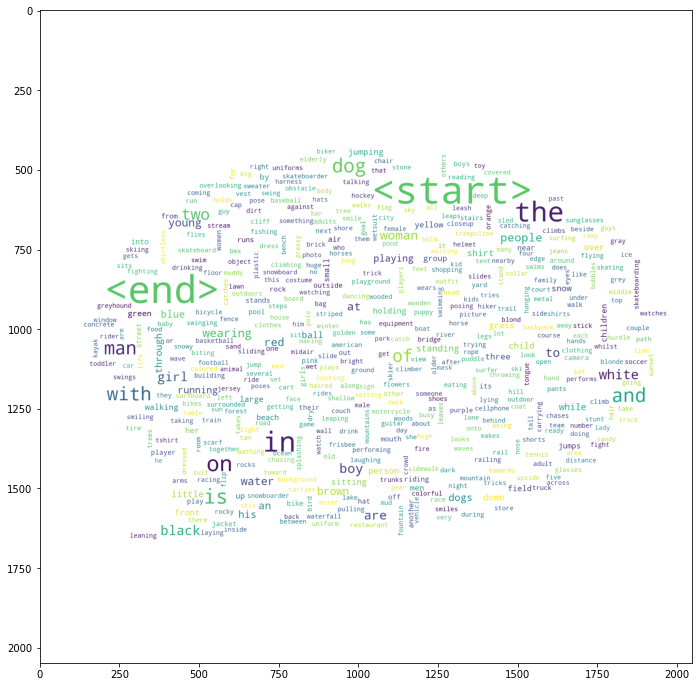

In [26]:
common_mask = np.array(Image.open('comment.png'))
wordcloud = WordCloud(background_color='white',
                    max_words = 500,
                    max_font_size = 120, 
                    random_state = 42,
                    mask = common_mask).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize=(20.0,12.0))
plt.imshow(wordcloud)

In [27]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
train_seqs_len=[len(seq) for seq in train_seqs] #storing all lengths in list.Can be used if needed in future
longest_word_length= max(train_seqs_len) #Python list method max returns the elements from the list with maximum value.

# Calculates the longest_word_length to pad all sequences to be the same length as the longest one.
print(longest_word_length)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

31
The shape of Caption vector is :(40455, 31)


We are padding zero at last using padding='post'. We know that start token acts as prompter and it expect some word after tat. Zero indicates no word and have no value at beginning.So,in order to not disturb the existing sequence structure we pad at end. This padding will cause problem while creating embedding vector.So we will be applying mask then

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [28]:
#checking to know about image format as we will be setting data format as none in tf.keras.applications.inception_v3.preprocess_input
tf.keras.backend.image_data_format() 

'channels_last'

Image data format have default as 'channels_last' which indicates Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels].


In [29]:
IMAGE_SHAPE= (299, 299)

In [30]:
#write your code here to create the dataset consisting of image paths
preprocessed_img=[]
for img in all_imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=0) #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

2023-04-19 12:00:31.455899: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-04-19 12:00:31.456519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46482 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:b1:00.0, compute capability: 8.6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


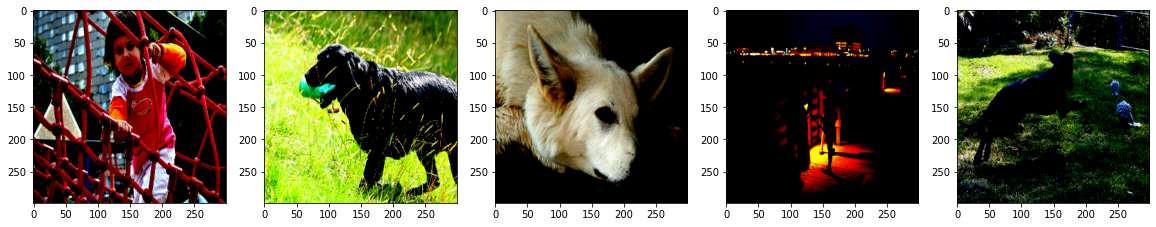

In [31]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    # ax.grid('off')

In [32]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

In [33]:
# all_img_vector

In [45]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
# sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)

# Mappng load_image across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
batchsize = 64
New_Image_Data= New_Image_Data.batch(batchsize,drop_remainder=False)

In [46]:
New_Image_Data

<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>

In [47]:
sample_img_batch, sample_cap_batch = next(iter(New_Image_Data))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

`Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.`

In [48]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer

In [49]:
image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

In [50]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    #fb_shape = features_for_batch.get_shape().as_list()
    #features_for_batch_flattened = tf.contrib.layers.flatten(fb_shape) 
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()

100%|██████████| 127/127 [00:20<00:00,  6.14it/s]


In [51]:
features_for_batch

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.22954422e-02, 0.00000000e+00, ...,
          2.30976909e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07633933e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.92967817e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.87934294e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.23010111e-02, 0.00000000e+00, 5.07272542e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.21276420e-01, 8.24914780e-03, ...,
          2.33851314e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [52]:
features_for_batch_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.2295442e-02, 0.0000000e+00, ...,
         2.3097691e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0763393e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9296782e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8793429e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6590554e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0778804e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.2041284e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5398984e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506630e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.3306166e-02, ...,
         1.2059258e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [53]:
len(image_features_dict)

8091

In [54]:
batch_feat.shape

TensorShape([64, 2048])

In [64]:
import more_itertools
top_5_items = more_itertools.take(5, image_features_dict.items())

top_5_items #printing first 5 elememts have dictionary

[('Flickr8k/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16993713],
         [0.        , 0.        , 1.0099012 , ..., 0.        , 0.        ,
          0.0605069 ],
         ...,
         [0.        , 0.        , 2.0376232 , ..., 1.2061558 , 0.        ,
          1.9903584 ],
         [0.        , 0.        , 0.90766126, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2566679 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('Flickr8k/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.6661557 , 0.46174023, ..., 0.        , 0.        ,
          3.3338666 ],
         [0.        , 1.2283397 , 0.        , ..., 0.        , 0.25316024,
          3.330676  ],
         [1.2834814 , 1.5162483 , 0.        , ..., 0.4684079 , 0.3654383 ,
          3.815

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [65]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2)

In [66]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [67]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image,captions):
  img_tensor = image_features_dict[image.decode('utf-8')]
  return img_tensor,captions  


### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [68]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

# Batch size
BATCH_SIZE = 64 ##tried with different batch sizes.

def gen_dataset(images_data, captions_data):
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset

In [69]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [70]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [71]:
embedding_dim = 256 
units = 512
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

max_length=31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [72]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) 
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features


In [73]:
encoder=Encoder(embedding_dim)

### Attention model

In [74]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

The attention model does a linear transformation of the input.So we are applying tanh function on top of it.The features produced from dense layer(FC layer) of encoder and hidden state of decoder are passed to tanh function and attention score is calculated

In other words, the tanh function is introduced to do non linear transformation and give smooth output .Since we need output in range (0,1), we apply softmax function on the obtained attention score which now gives the atttention weights.

Finally we computed a weighted sum of the attention weights on the feature vector and thus, derived our context vector.

This context vector produced are adaptive as they change for each and every time stamp.

### Decoder

In [75]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

We know that the encoder output along with hidden state is passed to attention model.The attention model produces context vector.This context vector is concatenated with embedded vector formed from embedding layer and passed to GRU.After passing the GRU output to dense layers,finally we are trying to obtain output in shape of vocab_size as we need to assign probabilities for each and every word in vocabulary.

In [76]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [77]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [78]:
optimizer =tf.keras.optimizers.Adam(learning_rate=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [79]:
#we always need to choose appropriate loss function.Let us use crossentropy SparseCategoricalCrossentropy.
# It calculates loss between the labels and predictions.
# zero is causing discrepency.we dont want decoder to give importance to zero.so lets mask zero to false

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [80]:
import os

In [81]:
from keras.utils.vis_utils import plot_model
# plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [82]:
checkpoint_path = "weights"
# os.mkdir(checkpoint_path, exit_ok=True)
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [83]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [84]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [85]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions) 

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

We are using teacher forcing as training converges faster. Also, in the initial steps of training, the predictions of the model are very bad. If we are not using it, the hidden states of the model might be updated with the sequence of wrong predictions because of the relational understading present between words, and this mislead the model as errors will keep on adding, and the model will learn wrongly and perform badly at the end.So in order to train the model in right direction, we are doing this tweaking and forcing the model to predict correctly by passing the target word as the next input to the decoder

In [86]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [87]:
!nvidia-smi

Wed Apr 19 12:02:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:B1:00.0 Off |                  Off |
| 30%   38C    P2    76W / 300W |   9984MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [88]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:39<37:07, 159.10s/it]

For epoch: 1, the train loss is 1.452, & test loss is 1.211
Time taken for 1 epoch 158.9119007587433 sec

Test loss has been reduced from 100.000 to 1.211


 13%|█▎        | 2/15 [03:36<21:27, 99.00s/it] 

For epoch: 2, the train loss is 1.116, & test loss is 1.061
Time taken for 1 epoch 56.76863503456116 sec

Test loss has been reduced from 1.211 to 1.061


 20%|██        | 3/15 [04:32<15:56, 79.73s/it]

For epoch: 3, the train loss is 1.009, & test loss is 0.975
Time taken for 1 epoch 56.60381484031677 sec

Test loss has been reduced from 1.061 to 0.975


 27%|██▋       | 4/15 [05:30<13:02, 71.18s/it]

For epoch: 4, the train loss is 0.933, & test loss is 0.907
Time taken for 1 epoch 57.89892315864563 sec

Test loss has been reduced from 0.975 to 0.907


 33%|███▎      | 5/15 [06:28<11:03, 66.36s/it]

For epoch: 5, the train loss is 0.873, & test loss is 0.850
Time taken for 1 epoch 57.60100722312927 sec

Test loss has been reduced from 0.907 to 0.850


 40%|████      | 6/15 [07:27<09:35, 63.92s/it]

For epoch: 6, the train loss is 0.820, & test loss is 0.801
Time taken for 1 epoch 59.00025391578674 sec

Test loss has been reduced from 0.850 to 0.801


 47%|████▋     | 7/15 [08:24<08:13, 61.64s/it]

For epoch: 7, the train loss is 0.772, & test loss is 0.756
Time taken for 1 epoch 56.74433946609497 sec

Test loss has been reduced from 0.801 to 0.756
For epoch: 8, the train loss is 0.729, & test loss is 0.712
Time taken for 1 epoch 56.74783539772034 sec

Test loss has been reduced from 0.756 to 0.712


 60%|██████    | 9/15 [10:19<05:56, 59.44s/it]

For epoch: 9, the train loss is 0.688, & test loss is 0.672
Time taken for 1 epoch 57.68670701980591 sec

Test loss has been reduced from 0.712 to 0.672


 67%|██████▋   | 10/15 [11:17<04:53, 58.79s/it]

For epoch: 10, the train loss is 0.650, & test loss is 0.636
Time taken for 1 epoch 57.15051317214966 sec

Test loss has been reduced from 0.672 to 0.636


 73%|███████▎  | 11/15 [12:15<03:55, 58.79s/it]

For epoch: 11, the train loss is 0.614, & test loss is 0.604
Time taken for 1 epoch 58.58817458152771 sec

Test loss has been reduced from 0.636 to 0.604


 80%|████████  | 12/15 [13:15<02:57, 59.04s/it]

For epoch: 12, the train loss is 0.583, & test loss is 0.572
Time taken for 1 epoch 59.42054271697998 sec

Test loss has been reduced from 0.604 to 0.572
For epoch: 13, the train loss is 0.554, & test loss is 0.547
Time taken for 1 epoch 58.3676278591156 sec

Test loss has been reduced from 0.572 to 0.547


 93%|█████████▎| 14/15 [15:11<00:58, 58.53s/it]

For epoch: 14, the train loss is 0.525, & test loss is 0.517
Time taken for 1 epoch 57.47813677787781 sec

Test loss has been reduced from 0.547 to 0.517


100%|██████████| 15/15 [16:09<00:00, 64.66s/it]

For epoch: 15, the train loss is 0.500, & test loss is 0.493
Time taken for 1 epoch 58.07644319534302 sec

Test loss has been reduced from 0.517 to 0.493


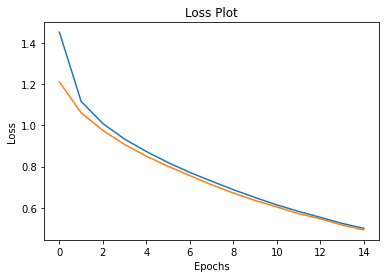

In [89]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [90]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [91]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [92]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [93]:
from nltk.translate.bleu_score import sentence_bleu

In [94]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

5194
BELU score: 84.64817248906141
Real Caption: little boy and dog run down hill
Prediction Caption: boy and dog run down hill


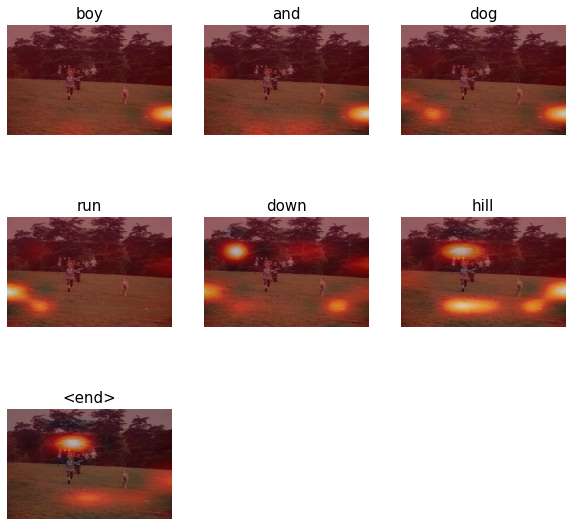

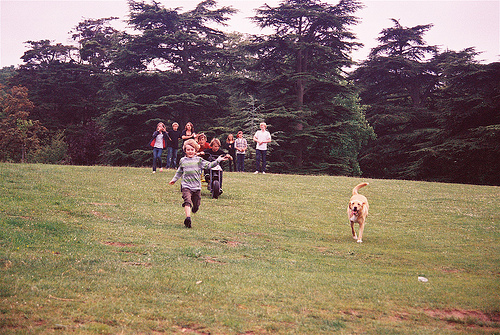

In [95]:
# 64, 2048
# features_shape = 2048
# attention_features_shape = 64
rid = np.random.randint(0, len(path_test))
print(rid)
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)


In [96]:
captions=beam_evaluate(test_image)
print(captions)

little and dog run and black run and black run and black run and black run and black run and black run and black run and black run and dog


In [97]:
# Import the required module for text to speech conversion
from gtts import gTTS
# Language in which you want to convert
language = 'en'
# Passing the text and language to the engine, 
myobj = gTTS(text=pred_caption, lang=language, slow=False)
# Saving the converted audio in a mp3 file named
myobj.save("Predicted_text.mp3")
# Playing the converted file
os.system("./Predicted_text.mp3")

/bin/dash: 1: ./Predicted_text.mp3: Permission denied


32256

#### Summary:

The project started with reading images and captions,displaying them.EDA is performed to understand about the given data set. Data cleaning is done which included cleaning caption file.

Data preprocessing is also performed which included :

* tokenizing the captions and forming an embeded vector,
* preprocessing images.

Post that a data set is splitted into train and test dataset.

InceptionV3 model is used.Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.

Here in this project, we are not classifying the images. Rather,we only need to extract a featire vector for our images.Hence we are removing the softmax layer from the model. The shape of the output of this layer is 8x8x2048. Then we squeezed that to a shape of (64, 2048).

This feature vector is given as input to CNN Encoder which had a single fully connected layer. To tell in abstract way,we can say that output from the encoder, hidden state(initialized to 0), and start token is passed as input to the decoder.

The decoder (RNN -here GRU) attends over the image to predict the next word. We used the attention model to make our decoder focus on a particular part of the image at a time rather than focusing on the entire image. This also reduces noise and improves accuracy.The decoder returns the predicted caption and the decoder's hidden state as output. which is sent back to the model and the predictions are used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy".We also used teacher forcing to decide the next input to the decoder.

The decoder stop predicting when the model predicts the end token.

The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

Finally, we are using the "BLEU score"(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption